# Result

Here are presented the first results of the analyse of Wikipedia RFA. For more detail about our work, method, timeline and objective, see the readme on the github reprository here: https://github.com/epfl-ada/ada-2024-project-supercoolteamname2024/tree/main

,username,categ1,categ2,categ3,categ4
0,!---slappdash---!,Entertainment,Music,Sports,Culture
1,%D0%90,Mass media,Lists,Geography,Education
2,'sed',Television,Cartoons,Culture,Humor
3,(.Y.),Music,Lists,Technology,Entertainment
4,(Julien:):,Sports,Politics,Society,History


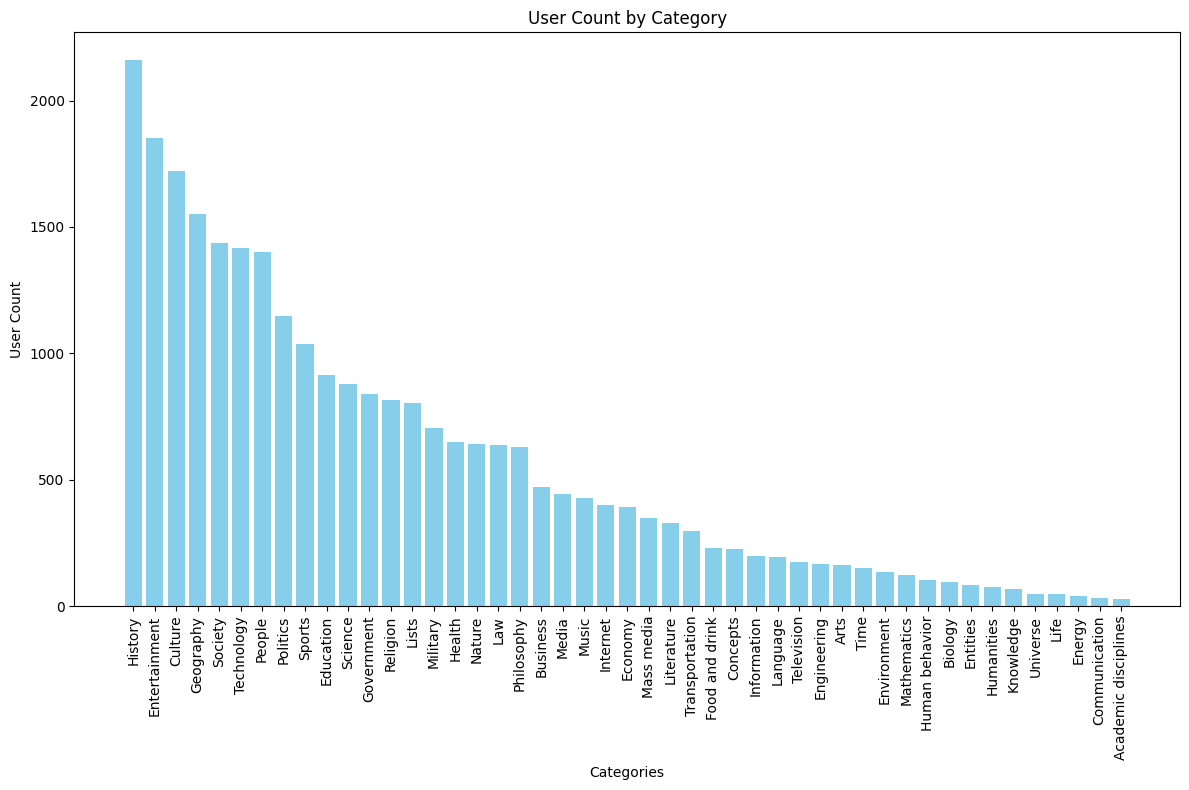

In [1]:
#Load
from src.scripts.EdPlots import *

# Categories distribution

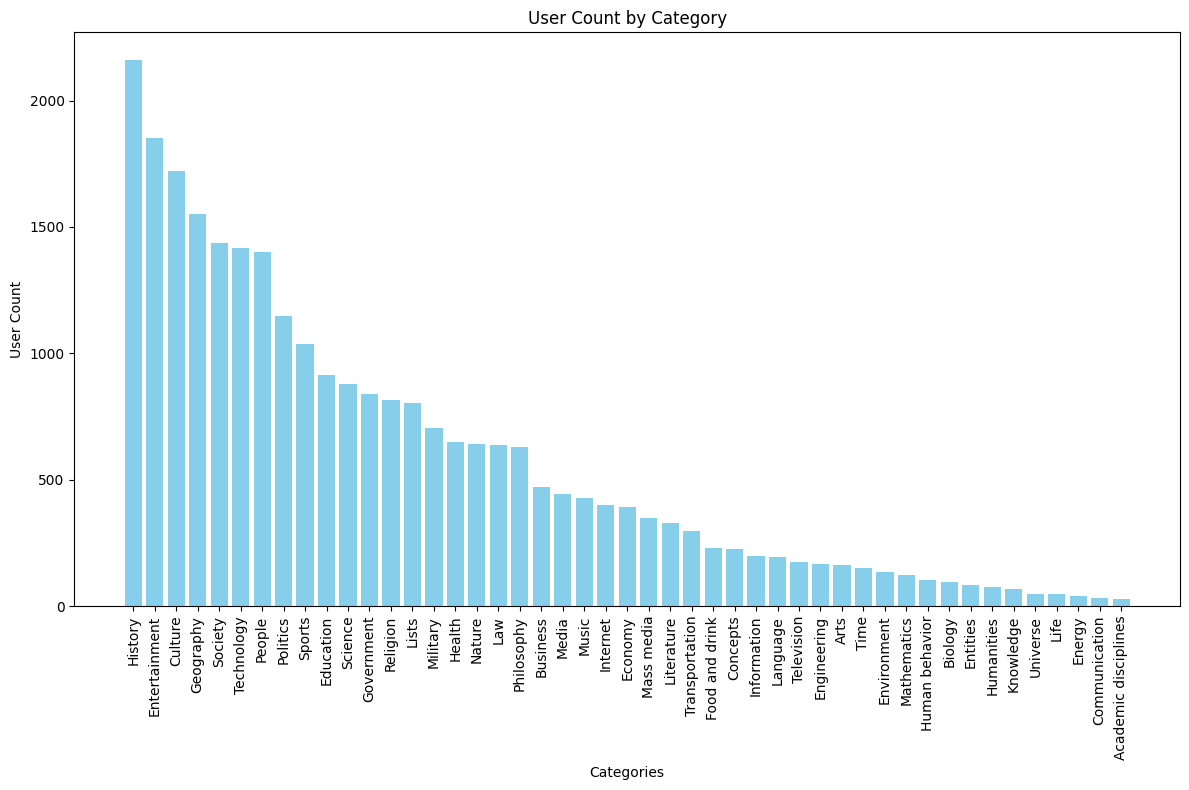

In [2]:
from src.scripts.EdPlots import *
top_15_categories = plot_top_categories(df, categories, top_n=15)



The bar chart illustrates a diverse distribution of user interests across various categories, with each user potentially belonging to up to 4 different categories. The varying sizes of these categories may be attributed to the breadth of the topics themselves, as some categories, like Technology, may encompass broader subtopics such as Internet. Notably, certain categories have significantly higher user counts, while others are relatively small. To ensure statistical significance in subsequent analyses, we plan to exclude the smallest categories where the sample size may be insufficient for robust conclusions

# Participation rate same/different group

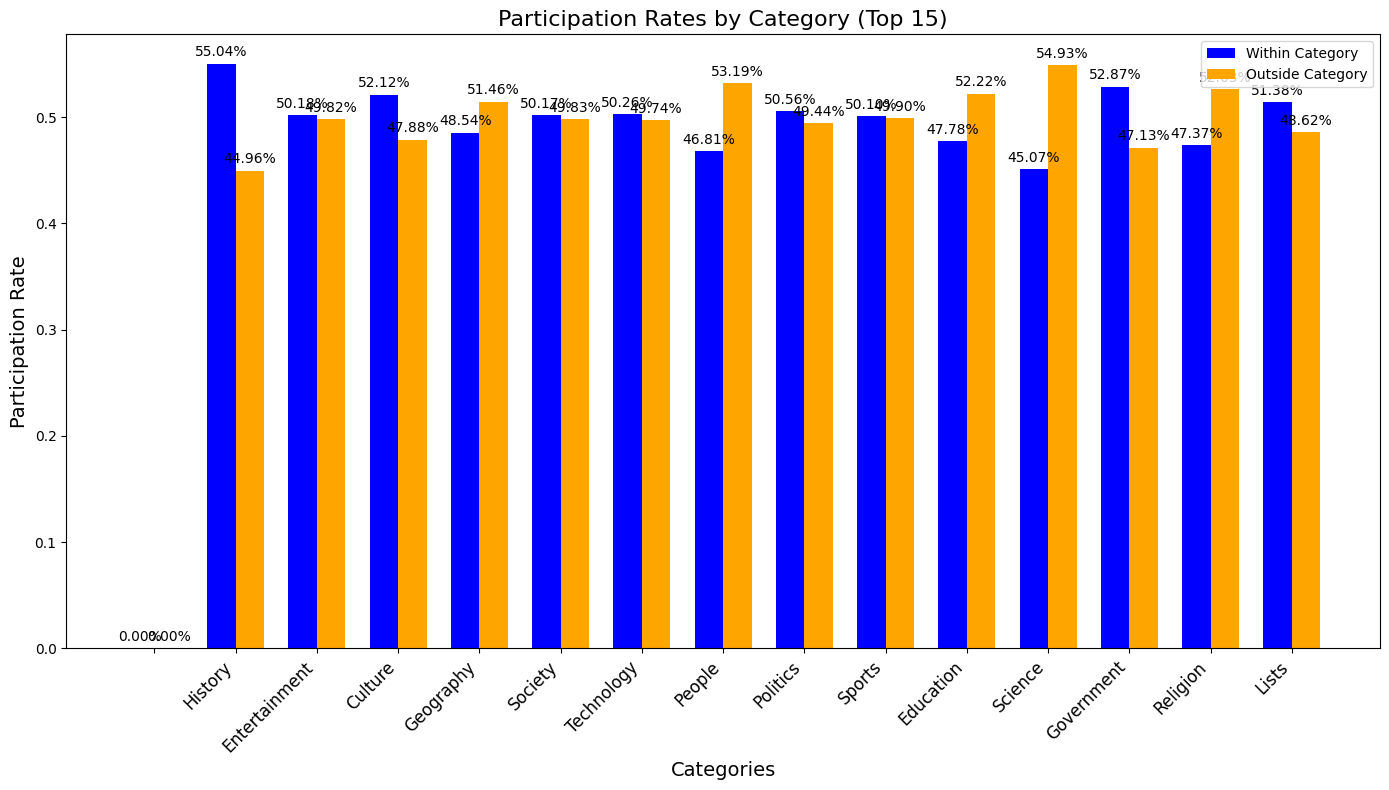

In [3]:
plot_participation_rates(df_vote, top_15_categories, title="Participation Rates by Category (Top 15)", top_n=15)

# Tolerance across same/different categories

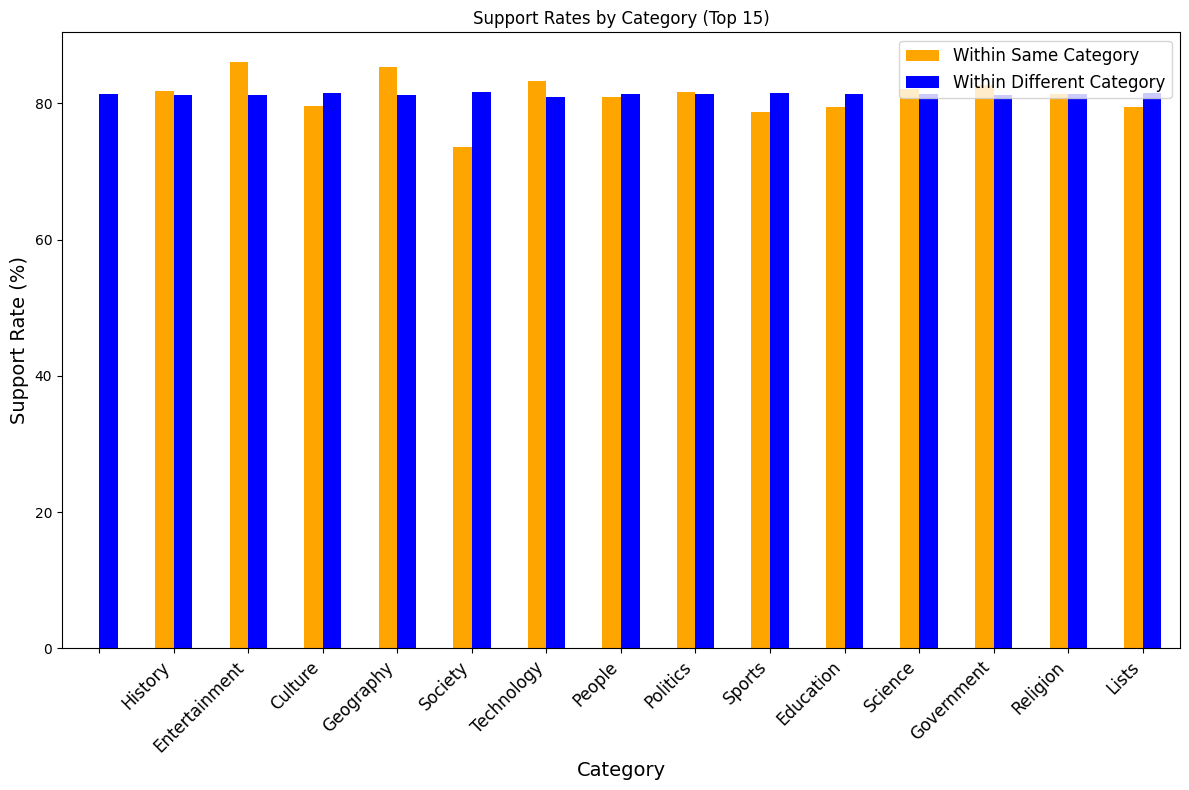

In [4]:
support_rates_df = plot_support_rates(df_vote, top_15_categories, title="Support Rates by Category (Top 15)",top_n=15)

Analyzing the top 10 largest categories, we observe that users are more inclined to participate in votes related to topics that align with their own interests. This can be explained by the fact that individuals are likely to feel more knowledgeable or proficient in certain areas, making them more comfortable expressing their opinions or casting votes. This trend persists, even in the mid-sized categories ranked 10 to 20, suggesting a consistent preference for engaging with familiar topics across the user base.


## Code


Total voters analyzed for trends: 1074
Trend
No Significant Change    1021
More Chill                 30
More Strict                23
Name: count, dtype: int64


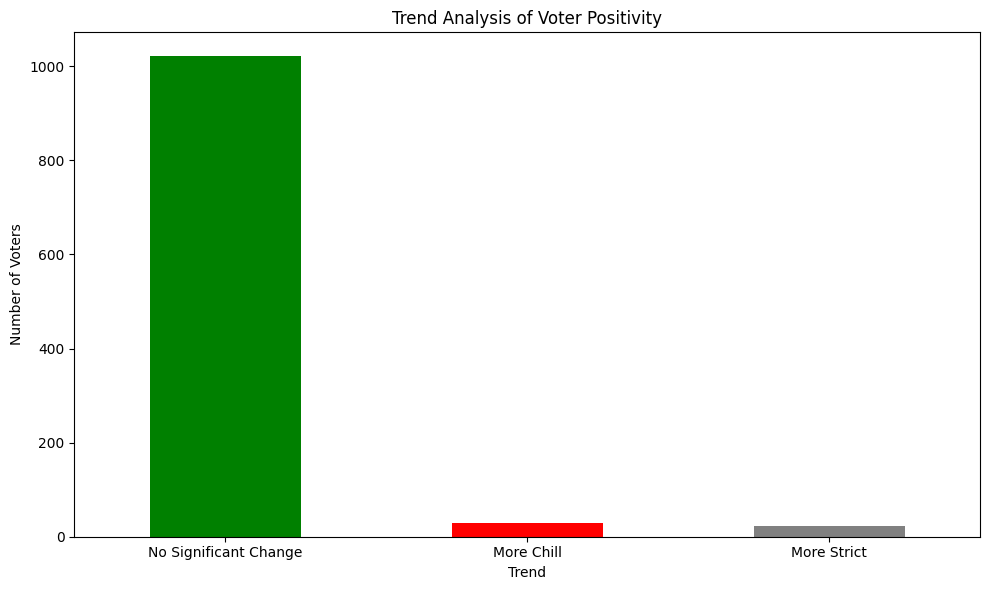

,Voter,Trend,Slope,p_value
0,*drew,No Significant Change,-0.250000,0.121038
1,172,No Significant Change,-0.008929,0.620802
2,28bytes,No Significant Change,-0.001001,0.994441
3,2over0,No Significant Change,0.000000,1.000000
4,6SJ7,No Significant Change,0.162500,0.243111
...,...,...,...,...
1069,thumperward,No Significant Change,0.016667,0.865160
1070,thunderboltz,No Significant Change,0.000000,1.000000
1071,violetriga,No Significant Change,0.500000,0.333333
1072,xeno,No Significant Change,0.027778,0.807272


In [5]:
# Call the function with df_vote
trends_df = analyze_voter_trends(df_vote)

# Optionally, inspect the returned DataFrame
display(trends_df)


## Table
 We tried to test the null hypothesis that tolerance rate is the same whether they are in the same/different category, p-values are on the last collumn.

# Code

# Votants Behavior 

We are studying behavior of votants, trying to see if they became more or less strict over the years, for that we look at voters that have voted in more than 1 year.

## Difference of behavior in the differents groups?

To test this we run the test with the null hypothesis is that the distribution of people being more strict/less strict and constant is the same among the groups than among the overall, the p-values are stored in the last collumn.

We see that there is not a huge difference in the distribution of behavior among groups

# Code

Chi-Square Statistic: 276.1526063361269
P-Value: 2.3076969656663427e-51


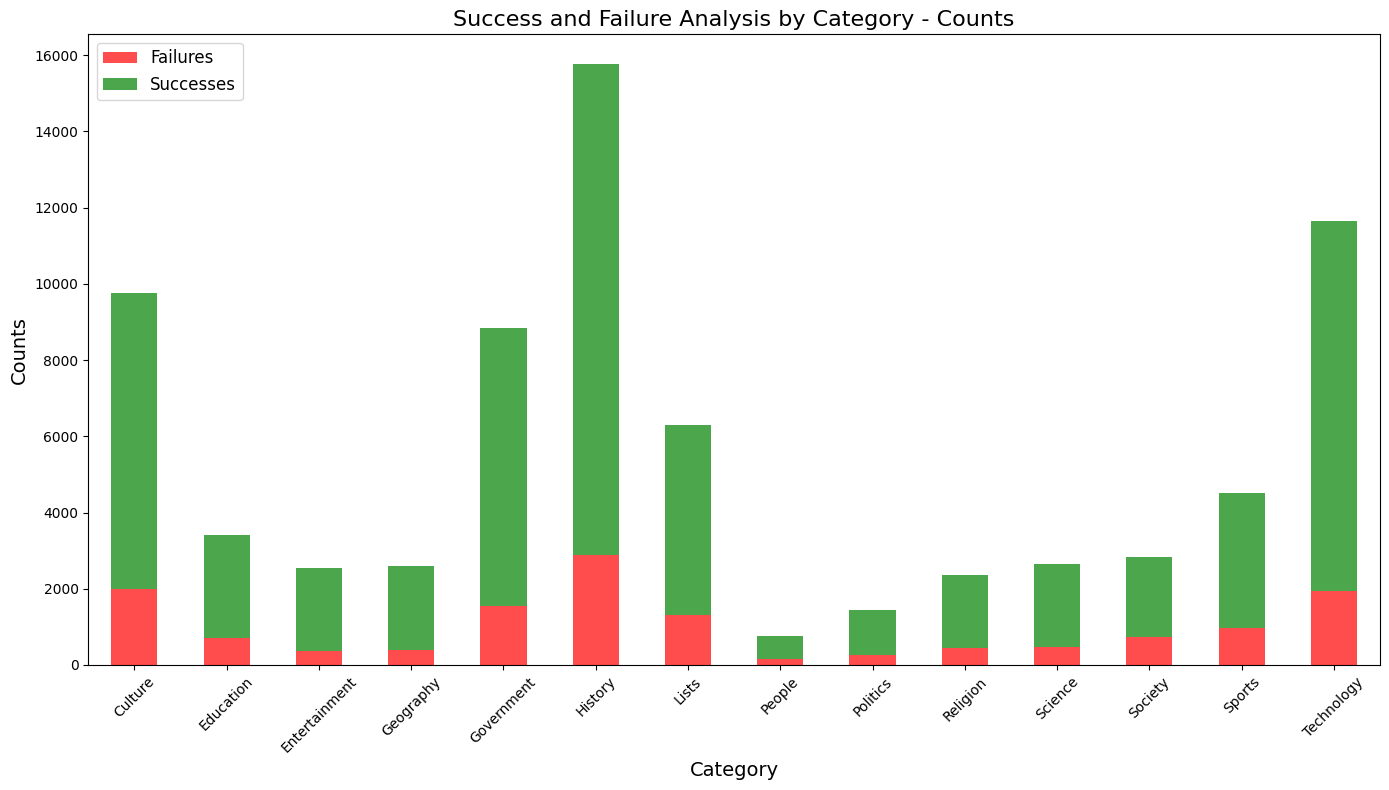

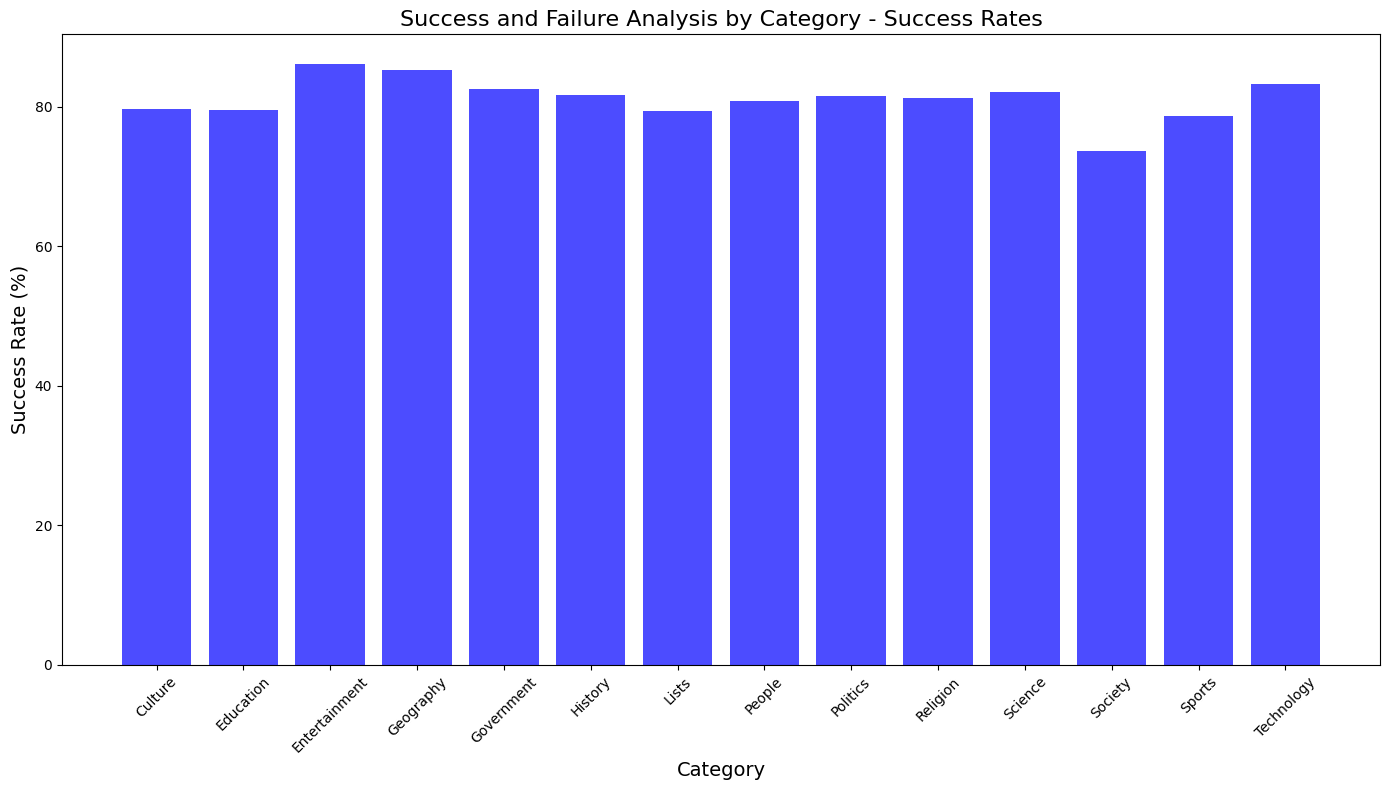

In [6]:
# Call the function with df_vote
success_failure_df = analyze_success_failure(df_vote, title="Success and Failure Analysis by Category")

# Does your subject of interest have an influence on your chance of admission??

Chi-square test result: chi2 = 276.1526063361269, p-value = 2.3076969656663427e-51
Statistically significant association between category and RfA success.


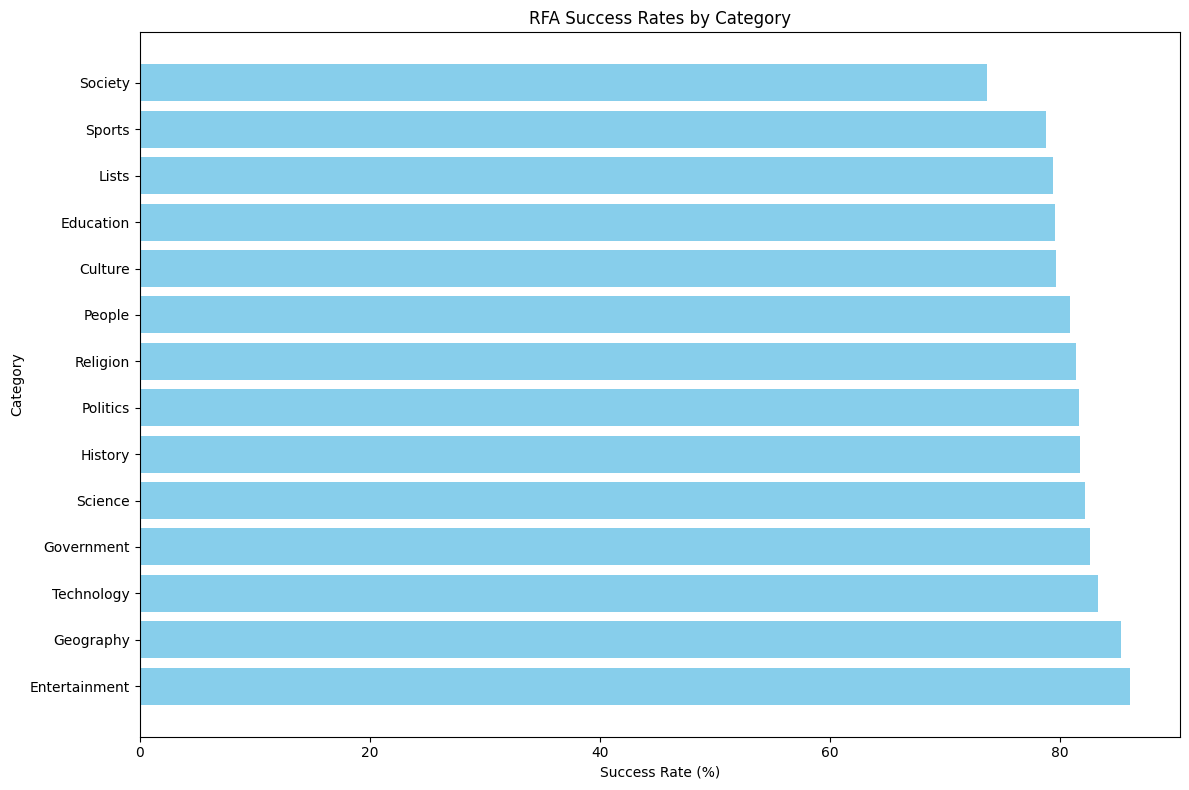

In [7]:
# Call the function with the success_data DataFrame
analyze_and_plot_success_rates(
    success_failure_df, 
    title="RFA Success Rates by Category"
)

# Code

# Admin scores distribution

We first plot the distribution of adminscores over the data set.

Let us notice that the boxplot for categories like, time, universe and others are not really significant since there are not enough users in these categories to fair results

## Approbation rates vs outcome

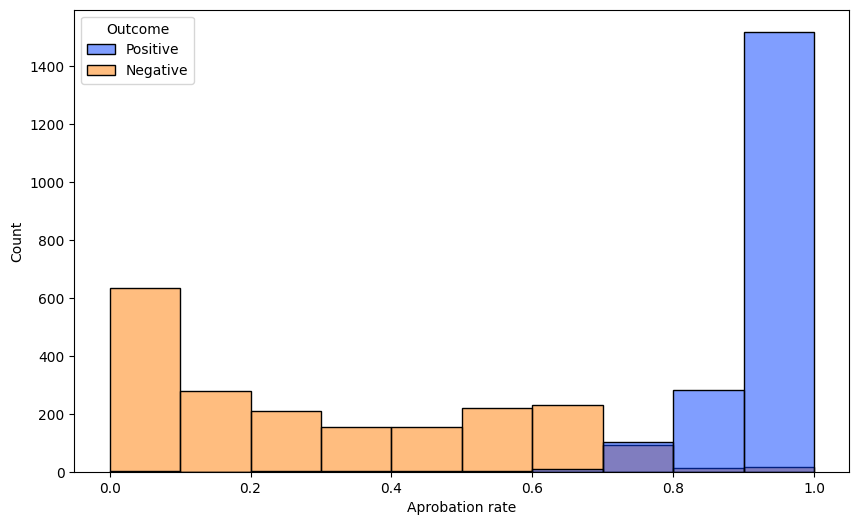

In [8]:
from src.scripts.GalPlots import *
plot_outcomes_approbation_rates("data/wiki-RfA.txt")

## Succes rate over years

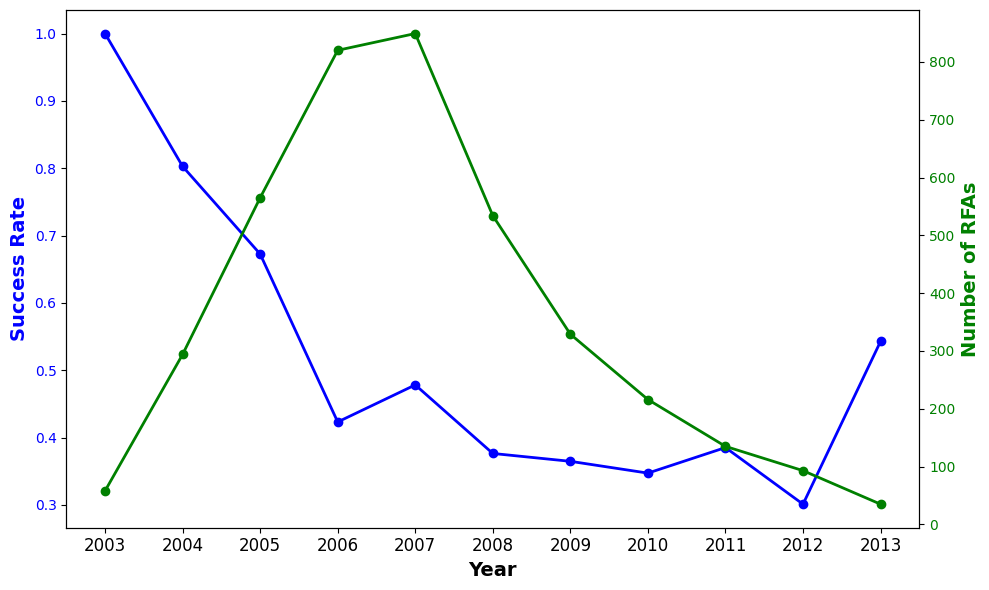

In [9]:
from src.scripts.GalPlots import *
plot_success_rates("data/wiki-RfA.txt")

## Admin score hist

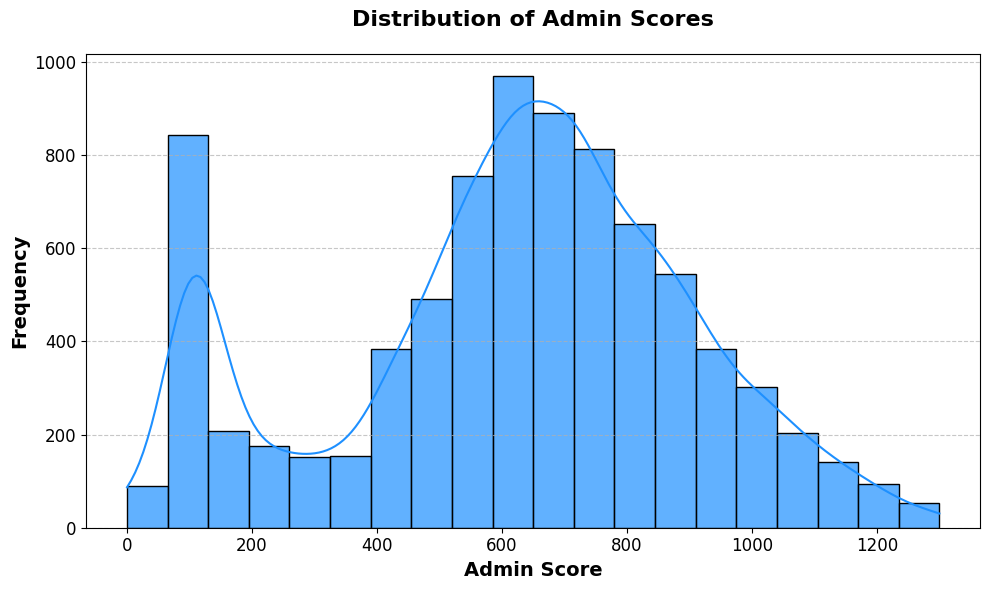

In [10]:
from src.scripts.GalPlots import *
plot_admin_scores_hist("data/scores.csv")

/Users/edou/Documents/GitHub/ada-2024-project-supercoolteamname2024/src/scripts/TallulaPlots.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='total_score', data=combined_df, palette=palette)


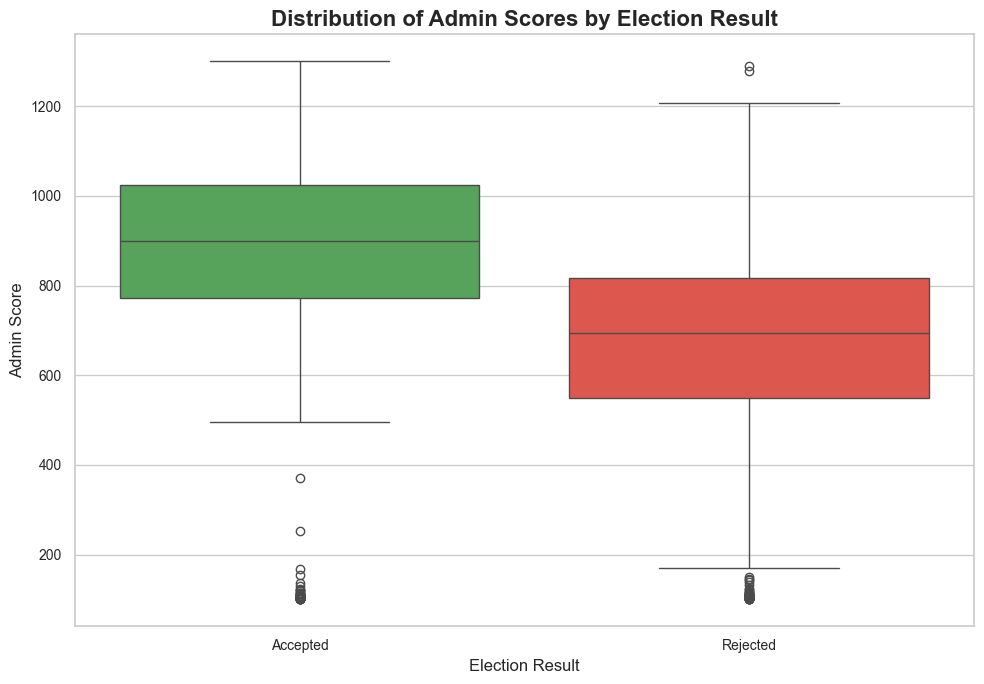

In [11]:
from src.scripts.TallulaPlots import *
Distribution_Admin_Scores('data/wiki-RfA.txt')